In [2]:
# Instal required libraries
%pip install numpy_financial
%pip install pyomo
%pip install -q condacolab
import condacolab
condacolab.install()
# This step might fail or crash the first time you run it. This is fine. 
# Just run the cell again and it will work.
!conda install -c conda-forge glpk


  Using cached numpy_financial-1.0.0-py3-none-any.whl.metadata (2.2 kB)
Using cached numpy_financial-1.0.0-py3-none-any.whl (14 kB)
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/4.1 MB 189.8 kB/s eta 0:00:15^C
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


RuntimeError: This module must ONLY run as part of a Colab notebook!

In [ ]:
# Install HyDesign
# Install hydesign if needed
import importlib
if not importlib.util.find_spec("hydesign"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/hydesign.git    

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import os

from hydesign.HiFiEMS import DEMS as EMS
from hydesign.HiFiEMS import utils
from hydesign.examples import examples_filepath

In [ ]:
# Connect to the Google Drive so you can read the data
from google.colab import drive
drive.mount('/content/drive')

# Change directory to the folder containing the current script
os.chdir("/content/drive/MyDrive/HPP_EMS_Assignment")



### 1. Input data analysis

This assignment is based on the HyDesign tool. You are given time series data of forecasted and actual values for wind power, solar power, and spot price. 
- Compute the normalized root mean squared error (nRMSE) for each forecast.
- Rank the forecasts from most to least accuracy
- Briefly discuss how forecast accuracy might influence market participation strategies for a renewable energy operator.


In [3]:


dic = {'wind_fn': examples_filepath + "HiFiEMS_inputs/Power/Winddata2021_15min.csv",
       'solar_fn': examples_filepath + "HiFiEMS_inputs/Power/Solardata2021_15min.csv",
       'market_fn': examples_filepath + "HiFiEMS_inputs/Market/Market2021.csv",}

Wind_data = pd.read_csv(dic["wind_fn"])
Solar_data = pd.read_csv(dic["solar_fn"])
Market_data = pd.read_csv(dic["market_fn"])

start_date_plot = datetime(2021,1,1)
end_date_plot = datetime(2022,1,1)
date_range_15min = pd.date_range(start_date_plot,end_date_plot,freq='15min')
date_range_1h = pd.date_range(start_date_plot,end_date_plot,freq='1h')



Wind_data.index = date_range_15min[:-1]
Solar_data.index = date_range_15min[:-1]
Market_data.index = date_range_1h[:-1]

P_w_real = Wind_data['Measurement']
P_w_DA = Wind_data['DA']

P_s_real = Solar_data['Measurement']
P_s_DA = Solar_data['DA']

SP_DA = Market_data['SM_forecast']
SP_real = Market_data['SM_cleared']

RP_DA = Market_data['reg_forecast_DNN']
RP_real = Market_data['reg_cleared']




In [12]:
## Wind forecasting error distribution
## DA price forecasting error distribution
# Compute forecast errors
error_wind = P_w_DA - P_w_real
error_solar = P_s_DA - P_s_real
error_SP = SP_DA - SP_real

# RMSE
rmse_wind = np.sqrt(np.mean(error_wind**2))
rmse_solar = np.sqrt(np.mean(error_solar**2))
rmse_SP = np.sqrt(np.mean(error_SP**2))

# Means
mean_wind = np.mean(P_w_real)
mean_solar = np.mean(P_s_real)
mean_SP = np.mean(SP_real)

# Normalized RMSEs
nrmse_wind = rmse_wind / mean_wind
nrmse_solar = rmse_solar/ mean_solar
nrmse_SP = rmse_SP / mean_SP

print(f"Wind Forecast nRMSE: {nrmse_wind:.2%}")
print(f"Solar Forecast nRMSE: {nrmse_solar:.2%}")
print(f"Spot Price Forecast nRMSE: {nrmse_SP:.2%}")

# plt.figure(figsize=(12, 8))


# plt.subplot(3, 1, 1)
# plt.hist(error_wind, bins=50, edgecolor='black', alpha=0.7)
# plt.title('Forecast Error Distribution - wind power')
# plt.xlabel('Forecast Error (MW)')
# plt.ylabel('Frequency')
# plt.grid(True)

# plt.subplot(3, 1, 2)
# plt.hist(error_solar, bins=50, edgecolor='black', alpha=0.7)
# plt.title('Forecast Error Distribution - solar power')
# plt.xlabel('Forecast Error (MW)')
# plt.ylabel('Frequency')
# plt.grid(True)

# plt.subplot(3, 1, 3)
# plt.hist(error_SP, bins=50, edgecolor='black', alpha=0.7)
# plt.title('Forecast Error Distribution - spot price')
# plt.xlabel('Forecast Error (€/MWh)')
# plt.ylabel('Frequency')
# plt.grid(True)


# plt.tight_layout()
# plt.show()

Wind Forecast nRMSE: 76.09%
Solar Forecast nRMSE: 84.79%
Spot Price Forecast nRMSE: 38.01%


### 2. Bidding strategy analysis



This part will use the deterministic EMS in HyDesign.HiFiEMS to understand the bidding strategy of the HPP. In the following code, you are given two dictionaries "parameter_dict" and "simulation_dict". Please play with 
- parameter_dict['hpp_grid_connection']
- parameter_dict['wind_capacity']
- parameter_dict['solar_capacity']
- parameter_dict['battery_energy_capacity']
- parameter_dict['battery_power_capacity']
- simulation_dict['start_date']
- simulation_dict['number_of_run_day']

to analyze the bidding strategies. Note: it take time for larger simulation_dict['number_of_run_day'] values. It is recommanded to look like 1 to 7 days with any start date. You can focus on the following analysis and do it for different HPP configurations and dates:

- Explain the likely rationale behind the bidding pattern?



In [ ]:
parameter_dict = {
        
        # hpp parameters
        'hpp_grid_connection': 300,  # in MW

        # hpp wind parameters
        'wind_capacity': 150, #in MW


        # hpp solar parameters
        'solar_capacity': 0,  # in MW
       

        # hpp battery parameters
        'battery_energy_capacity': 120,  # in MWh
        'battery_power_capacity': 40,  # in MW
        'battery_minimum_SoC': 0.1,
        'battery_maximum_SoC': 0.9,
        'battery_initial_SoC': 0.1,
        'battery_hour_discharge_efficiency': 0.985,  #
        'battery_hour_charge_efficiency': 0.975,
        'battery_self_discharge_efficiency': 0,
        # hpp battery degradation parameters
        'battery_initial_degradation': 0,  
        'battery_marginal_degradation_cost': 142000, # in /MWh
        'battery_capital_cost': 142000, # in /MWh
        'degradation_in_optimization': 0, # 1:yes 0:no
        
        # bid parameters
        'max_up_bid': 50,
        'max_dw_bid': 50,
        'min_up_bid': 5,
        'min_dw_bid': 5,
        
        # interval parameters: note that DI must <= SI
        'dispatch_interval': 1/4,
        'settlement_interval': 1/4,
        
        'imbalance_fee': 0.13,  # DK: 0.13 €/MWh, other Nordic countries: , others: 0.001
    }



simulation_dict = {
        'wind_as_component': 1,
        'solar_as_component': 1,  # 
        'battery_as_component': 1,
        'start_date': '3/15/21',
        'number_of_run_day': 10,   # 
        'out_dir':"./Outputs/day_2/DEMS/",

        'DA_wind': "DA",   #DA, Measurement
        'HA_wind': "HA" ,  #HA, Measurement
        'FMA_wind':"RT",#5min_ahead, Measurement
        'DA_solar': "DA",
        'HA_solar': "HA",
        'FMA_solar': "RT",
        'SP': "SM_forecast",  # SM_forecast;SM_cleared
        'RP': "reg_forecast", #reg_cleared;reg_forecast_pre
        'BP': 1, #1:forecast value 2: perfect value
        
        # Data
        'wind_df': Wind_data,
        'solar_df': Solar_data,
        'market_df': Market_data,
        
        # for DDEMS (spot market) -- Historical data
        'history_wind_fn': examples_filepath + "HiFiEMS_inputs/Winddata2022_15min.csv",
        'history_market_fn': examples_filepath + "HiFiEMS_inputs/Market2021.csv",
        
        # for REMS (balancing market)
        'HA_wind_error_ub': "5%_fc_error",
        'HA_wind_error_lb': "95%_fc_error",
        
        # for SEMS
        #'wind_scenario_fn': "../Data/Winddata2022_15min.csv",  # "../Data/probabilistic_wind2022.csv"
        'price_scenario_fn': None,  # "../Data/xxx.csv", if None then use the build in method to generate price scenarios
        'number_of_wind_scenario': 3, 
        'number_of_price_scenario': 3, 
    }

out_keys = ['P_HPP_SM_t_opt',
                'SM_price_cleared',
                'BM_dw_price_cleared',
                'BM_up_price_cleared',
                'P_HPP_RT_ts',
                'P_HPP_RT_refs',
                'P_HPP_UP_bid_ts',
                'P_HPP_DW_bid_ts',
                's_UP_t',
                's_DW_t',
                'residual_imbalance',
                'RES_RT_cur_ts',
                'P_dis_RT_ts',
                'P_cha_RT_ts',
                'SoC_ts']
res = utils.run(
        parameter_dict = parameter_dict,
        simulation_dict = simulation_dict,
        EMS = EMS,
        EMStype="DEMS",
        BM_model=False,
        RD_model=False
       )   # run EMS with only spot market optimization

lst = []
for k, r in zip(out_keys, res):
    lst.append({'key': k, 'sum': r.sum(), 'mean': r.mean(), 'size':r.size})
df = pd.DataFrame(lst)



 91%|█████████ | 10/11 [00:19<00:01,  1.94s/it]

300
                    key           sum          mean  size
0        P_HPP_SM_t_opt  2.861134e+03  2.980348e+01    96
1      SM_price_cleared  1.258530e+03  5.243875e+01    24
2   BM_dw_price_cleared  8.388100e+02  3.495042e+01    24
3   BM_up_price_cleared  1.341240e+03  5.588500e+01    24
4           P_HPP_RT_ts  3.296091e+03  3.433428e+01    96
5         P_HPP_RT_refs  2.861134e+03  2.980348e+01    96
6       P_HPP_UP_bid_ts  0.000000e+00  0.000000e+00    96
7       P_HPP_DW_bid_ts  0.000000e+00  0.000000e+00    96
8                s_UP_t  0.000000e+00  0.000000e+00    96
9                s_DW_t  0.000000e+00  0.000000e+00    96
10   residual_imbalance  2.674187e+02  2.785611e+00    96
11        RES_RT_cur_ts -3.552714e-15 -3.700743e-17    96
12          P_dis_RT_ts  7.046635e+02  7.340245e+00    96
13          P_cha_RT_ts  1.078517e+03  1.123456e+01    96
14               SoC_ts  5.632695e+01  5.867390e-01    96


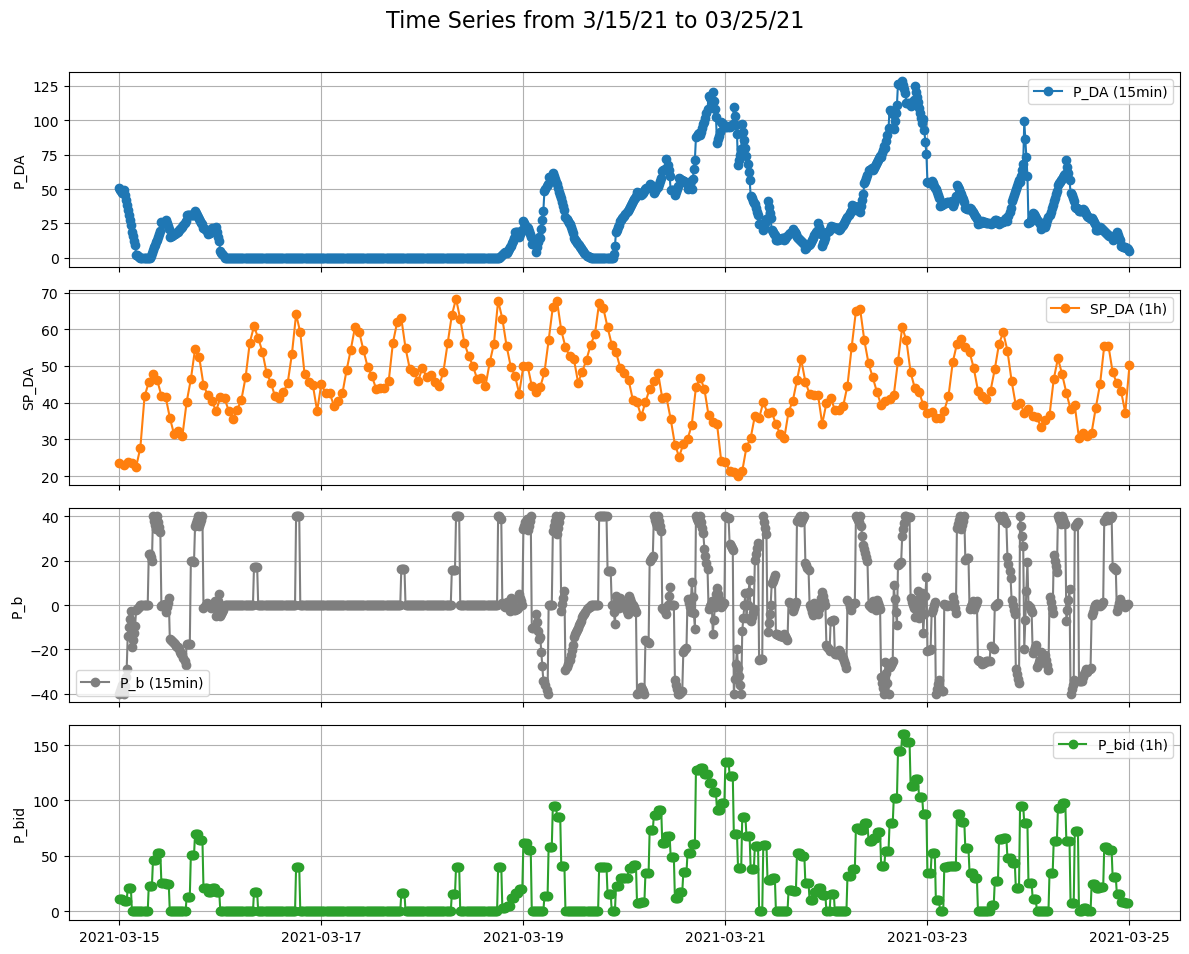

In [67]:
## wind forecast/DA price/DA schedule/SoC/curtailment (one day example to see how schedule respond to input data)

output_schedule_ts_filename = './Outputs/day_2/DEMS/schedule.csv'
output_SoC_ts_filename = './Outputs/day_2/DEMS/SoC.csv'
output_curtailment_ts_filename = './Outputs/day_2/DEMS/curtailment.csv'

schedule = pd.read_csv(output_schedule_ts_filename)
SoC = pd.read_csv(output_SoC_ts_filename)
curtailment = pd.read_csv(output_curtailment_ts_filename)


start_date = simulation_dict['start_date']
num_of_days = simulation_dict['number_of_run_day']
end_date = (datetime.strptime(start_date, "%m/%d/%y") + timedelta(days=num_of_days)).strftime("%m/%d/%y")

date_range_15min = pd.date_range(start=start_date, end=end_date, freq='15min')

schedule.index = date_range_15min[:-1]
SoC.index = date_range_15min[:-1]
curtailment.index = date_range_15min[:-1]



P_bid = schedule['SM']
SoC = SoC['SoC']
P_cur = abs(curtailment['RES_cur'])





date_range_15min_mask = (P_w_DA.index >= start_date) & (P_w_DA.index <= end_date)
date_range_1h_mask = (SP_DA.index >= start_date) & (SP_DA.index <= end_date)


P_DA_day = P_w_DA[date_range_15min_mask]*parameter_dict['wind_capacity'] + P_s_DA[date_range_15min_mask]*parameter_dict['solar_capacity']
SP_DA_day = SP_DA[date_range_1h_mask]
P_bid_day = P_bid
SoC_day = SoC
P_cur_day = P_cur
P_b_day = P_bid_day - P_DA_day

fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

axs[0].plot(P_DA_day, label='P_DA (15min)', color='tab:blue', marker='o')
axs[0].set_ylabel('P_DA')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(SP_DA_day, label='SP_DA (1h)', color='tab:orange', marker='o')
axs[1].set_ylabel('SP_DA')
axs[1].legend()
axs[1].grid(True)

axs[2].plot(P_b_day, label='P_b (15min)', color='tab:gray', marker='o')
axs[2].set_ylabel('P_b')
axs[2].legend()
axs[2].grid(True)

axs[3].plot(P_bid_day, label='P_bid (1h)', color='tab:green', marker='o')
axs[3].set_ylabel('P_bid')
axs[3].legend()
axs[3].grid(True)



# axs[4].plot(P_cur_day, label='Curtailment (P_cur)', color='tab:red', marker='o')
# axs[4].set_ylabel('P_cur')
# axs[4].legend()
# axs[4].grid(True)

# axs[5].plot(SoC_day, label='SoC (15min)', color='tab:purple', marker='o')
# axs[5].set_ylabel('SoC')
# axs[5].set_xlabel('Time')
# axs[5].legend()
# axs[5].grid(True)

fig.suptitle(f'Time Series from {start_date} to {end_date}', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

### 3. Evaluation the lifetime performance of a HPP using DEMS

This part will use HyDesign to evaluate the lifetime performance of a HPP based on the determinisitc EMS. You can tune the inputs dictionary and analyze the results. Please consider the following questions:
- Is the given HPP configuration a profitable configuration?
- Can you find a HPP configuration which has better NPV/CAPEX?

In [80]:


def main():
    if __name__ == '__main__':
        import os
        
        from hydesign.examples import examples_filepath
        from hydesign.assembly.hpp_assembly_hifi_dems import hpp_model
        
        sim_pars_fn = os.path.join(examples_filepath, 'Europe/hpp_pars_HiFiEMS.yml')
        hpp = hpp_model(sim_pars_fn=sim_pars_fn,
                        input_ts_da=os.path.join(examples_filepath, 'HiFiEMS_inputs/Weather/input_ts_DA.csv'),
                        input_ts_ha=os.path.join(examples_filepath, 'HiFiEMS_inputs/Weather/input_ts_HA.csv'),
                        input_ts_rt=os.path.join(examples_filepath, 'HiFiEMS_inputs/Weather/input_ts_RT.csv'),
                        market_fn=os.path.join(examples_filepath, 'HiFiEMS_inputs/Market/Market2021.csv'),)
        inputs = dict(clearance=20, 
                      sp=350,
                      p_rated=10, 
                      Nwt=12, 
                      wind_MW_per_km2=6,
                      solar_MW=10,
                      surface_tilt=25, 
                      surface_azimuth=180, 
                      DC_AC_ratio=1.5,
                      b_P=40,
                      b_E_h=3,
                      )
        
        res = hpp.evaluate(**inputs)
        hpp.print_design(list(inputs.values()), res)

    return hpp
hpp = main()



Fixed parameters on the site
-------------------------------
longitude = 8.594398
latitude = 56.227322
altitude = 85


 98%|█████████▊| 50/51 [01:50<00:02,  2.22s/it]

100.0



Design:
---------------
clearance [m]: 20.000
sp [W/m2]: 350.000
p_rated [MW]: 10.000
Nwt: 12.000
wind_MW_per_km2 [MW/km2]: 6.000
solar_MW [MW]: 10.000
surface_tilt [deg]: 25.000
surface_azimuth [deg]: 180.000
DC_AC_ratio: 1.500
b_P [MW]: 40.000
b_E_h [h]: 3.000


NPV_over_CAPEX: 1.262
NPV [MEuro]: 173.228
IRR: 0.135
LCOE [Euro/MWh]: 12.966
Revenues [MEuro]: 19.113
CAPEX [MEuro]: 137.214
OPEX [MEuro]: 5.114
Wind CAPEX [MEuro]: 103.930
Wind OPEX [MEuro]: 5.047
PV CAPEX [MEuro]: 3.350
PV OPEX [MEuro]: 0.068
Batt CAPEX [MEuro]: 6.940
Batt OPEX [MEuro]: 0.000
Shared CAPEX [MEuro]: 22.994
Shared Opex [MEuro]: 0.000
penalty lifetime [MEuro]: 0.000
AEP [GWh]: 1149.870
GUF: 1.313
grid [MW]: 100.000
wind [MW]: 120.000
solar [MW]: 10.000
Battery Energy [MWh]: 120.000
Battery Power [MW]: 40.000
Total curtailment [GWh]: 876.000
Total curtailment with deg [GWh]: 634.029
Awpp [km2]: 20.000
Apvp [km2]: 0.123
Plant area [km2]: 20.000
Rotor diam [m]: 190.731
Hub height [m]: 115.365
Number of batteries